In [1]:
import cv2
import torch
import random
import torchreid
import numpy as np
from PIL import Image
from threading import Thread
from datetime import datetime
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

# Models

## Person_ReIdentification 

### Defining Dataset and PreProcessing Engine 

In [2]:
datamanager = torchreid.data.ImageDataManager(
    root="reid-data",
    sources="market1501",
    targets="market1501",
    height=256,
    width=128,
    batch_size_train=32,
    batch_size_test=100,
    transforms=["random_flip", "random_crop"]
)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Resize((256,128))
])

Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
=> Loading train (source) dataset
=> Loaded Market1501
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |         6
  ----------------------------------------
=> Loading test (target) dataset


/home/amirali/Desktop/Files/win/All Desktop/deep-person-reid-master/torchreid/data/datasets/image/market1501.py:37: UserWarning: The current data structure is deprecated. Please put data folders such as "bounding_box_train" under "Market-1501-v15.09.15".
  warnings.warn(


=> Loaded Market1501
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |         6
  ----------------------------------------


  **************** Summary ****************
  source            : ['market1501']
  # source datasets : 1
  # source ids      : 751
  # source images   : 12936
  # source cameras  : 6
  target            : ['market1501']
  *****************************************




### Defining Model based on PreTrained Weights 

In [3]:
myModel = torchreid.models.build_model(
    name="xception",
    num_classes=datamanager.num_train_pids, #751
    loss="softmax",
    pretrained=True
)

myModel = myModel.cuda()

checkpoint = torch.load('./log4/Xception/model/model.pth.tar-80')
myModel.load_state_dict(checkpoint['state_dict'])

myModel.eval()

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv2d(128, 128, kernel_size=(3

## Yolo 

In [4]:
things_model = torch.hub.load('ultralytics/yolov5', 'custom', path='./yolov5x6.pt',device='cuda:0')
%matplotlib inline

Using cache found in /home/amirali/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-1-10 Python-3.10.6 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3060, 12050MiB)

Fusing layers... 
YOLOv5x6 summary: 574 layers, 140730220 parameters, 0 gradients
Adding AutoShape... 


# Cam Settings

In [5]:
class ThreadedCamera(object):
    def __init__(self, source='cam:Ashkan123@192.168.172.199:88/videoMain'):

        self.capture = cv2.VideoCapture(f'rtsp://{source}')

        self.thread = Thread(target = self.update, args = ())
        self.thread.daemon = True
        self.thread.start()

        self.status = False
        self.frame  = None

    def update(self):
        while True:
            if self.capture.isOpened(): (self.status, self.frame) = self.capture.read()
            else: continue

    def grab_frame(self):
        if self.status: return self.frame
        else: return None 
    
    def end_frame(self):
        self.capture.release()

In [6]:
def Mouse_Click(event, x, y, flags, param):
    global ROI_Region
    global img_original

    if event == cv2.EVENT_RBUTTONDOWN:
        ROI_Region = cv2.selectROI("Select Area",img_original)
        print(ROI_Region)
#         cv2.destroyAllWindows()
    elif event == cv2.EVENT_MBUTTONDOWN: ROI_Region = [0,0,0,0]
    else: pass

# Functions

## PreProcess Light

In [7]:
def Pre_Proc_Light(img):
    lightness = np.mean(img)
    if lightness < 95:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    else: return img

## Detecting Persons on a single image

In [8]:
def Person_Detection(img,img_orig,ROI_Region):
    imgs = []
    save_flag = True
    img_original = img_orig.copy()
    
    now_time = datetime.now().strftime("%Y_%m_%d---%I_%M_%S---%p")
    img = np.array(Image.fromarray(img))
    img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
    
    with torch.no_grad(): results = things_model(img)

    if len(results.xyxy[0]) == 0: pass
    else:
        img_original = cv2.cvtColor(np.array(img_original),cv2.COLOR_BGR2RGB)
        
        for indx,res in enumerate(results.xyxy[0]):
            
            predict = results.pandas().xyxy[0]['name'][indx]
            
            if predict == 'person': pass
            else: continue

            res = np.array(res.detach().cpu())
            if res[4]*100 < 45: save_flag = False
            else: 
                x = round(res[0])
                y = round(res[1])
                w = round(res[2])
                h = round(res[3])
                
                imgs.append((img[y:h,x:w],[x,y,h,w]))
                
                img_original = cv2.rectangle(np.array(img_original), (x+ROI_Region[0], y+ROI_Region[1],abs(w-(x)),abs(h-(y))), (255,0,0), 2)
                img_original = cv2.putText(np.array(img_original), f"{predict}", (x+ROI_Region[0], y+ROI_Region[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),2,cv2.LINE_AA)               

        if save_flag and not (len(imgs) == 0):
            img_original = cv2.cvtColor(np.array(img_original),cv2.COLOR_RGB2BGR)
            cv2.imwrite(f'./Images/{now_time}.jpg',img_original)
            img_original = cv2.cvtColor(np.array(img_original),cv2.COLOR_BGR2RGB)
        else: pass
        
    return imgs

## Person ReIdentification Function

In [9]:
def Person_ReIdentification(img,thresh=13,telorance=0.5):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = Pre_Proc_Light(img)
    img = transform(img)
    x = myModel(img.unsqueeze(0).float().cuda())
    
    for indx,img in database:
        if torch.cdist(x, img, p=2.0).detach().cpu()[0][0] < thresh: return indx,x,True
        elif torch.cdist(x, img, p=2.0).detach().cpu()[0][0] <= thresh + telorance: return indx,x,True
        else: continue
    return 0,x,False

# Inits

In [10]:
img_original = None
imgs_Saved = []
# ROI_Region = [0,0,0,0]
ROI_Region = [360, 144, 783, 547]
database,rgb_colors = [],[]
cap = cv2.VideoCapture('./Samples_on_Resnet_50/Sample_3/video_2.mp4')
# streamer = ThreadedCamera('rtsp:Ashkan321@172.16.60.121:554/Streaming/Channels/001')

# Evaluation

In [11]:
while True:
    _,img_original = cap.read()
#     img_original = streamer.grab_frame()
    
    try: img_original = Image.fromarray(img_original)
    except AttributeError: continue
    
    if img_original is None: img_original = np.zeros([750,1250,3],dtype=np.uint8)
    else: img_original = cv2.resize(np.array(img_original), (1250, 750))

    img_cropped = img_original.copy()
    try:        
        if ROI_Region[0] == ROI_Region[1] and ROI_Region[2] == ROI_Region[3]:
            if ROI_Region[0] == 0 and ROI_Region[0] == ROI_Region[3]: pass
            else: 
                img_cropped = img_cropped[int(ROI_Region[1]):int(ROI_Region[1]+ROI_Region[3]),int(ROI_Region[0]):int(ROI_Region[0]+ROI_Region[2])]
#                 img_cropped = cv2.fastNlMeansDenoisingColored(img_cropped,None,10,20,7,21)
        else: 
            img_cropped = img_cropped[int(ROI_Region[1]):int(ROI_Region[1]+ROI_Region[3]),int(ROI_Region[0]):int(ROI_Region[0]+ROI_Region[2])]
#             img_cropped = cv2.fastNlMeansDenoisingColored(img_cropped,None,10,20,7,21) 

    except IndexError: pass

    imgs = Person_Detection(img_cropped,img_original,ROI_Region)

    if len(imgs) == 0: pass
    else: 
        for img,cordinations in imgs:
            x = cordinations[0]
            y = cordinations[1]
            h = cordinations[2]
            w = cordinations[3]
            
            if img.shpe[0] < 100 or img.shape[1] < 100: continue
                
            res,emb,flag = Person_ReIdentification(img,13,0.7)
            imgs_Saved.append(('res',img))
                              
            if flag: pass
            else:
                database.append((len(database)+1,emb))
                res = len(database)
                imgs_Saved.append((res,img))
                
            try: color = rgb_colors[res]
            except IndexError:
                r = random.randrange(1, 256, 20)
                g = random.randrange(1, 256, 20)
                b = random.randrange(1, 256, 20)
                color = (r,g,b)
                rgb_colors.append(color)

            img_original = cv2.rectangle(np.array(img_original), (x+ROI_Region[0], y+ROI_Region[1],abs(w-(x)),abs(h-(y))), color, 2)
            img_original = cv2.putText(np.array(img_original), f"{res}", (x+ROI_Region[0], y+ROI_Region[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, color,2,cv2.LINE_AA)
                
    
    cv2.imshow('Person_ReIdentification', np.array(img_original))
    cv2.setMouseCallback('Person_ReIdentification', Mouse_Click)
    
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        cv2.destroyAllWindows()
        cap.release()
#         streamer.end_frame()
        break

cv2.destroyAllWindows()
cap.release()

In [13]:
torch.cdist(database[4][1], database[2][1], p=2.0).detach().cpu()[0][0]

tensor(13.74519)

# Error Analysis

In [88]:
for indx,(_,i) in enumerate(database):
    print(f'{indx} - {i.shape}')

0 - torch.Size([1, 2048])
1 - torch.Size([1, 2048])
2 - torch.Size([1, 2048])
3 - torch.Size([1, 2048])
4 - torch.Size([1, 2048])
5 - torch.Size([1, 2048])
6 - torch.Size([1, 2048])
7 - torch.Size([1, 2048])
8 - torch.Size([1, 2048])
9 - torch.Size([1, 2048])
10 - torch.Size([1, 2048])
11 - torch.Size([1, 2048])
12 - torch.Size([1, 2048])
13 - torch.Size([1, 2048])
14 - torch.Size([1, 2048])
15 - torch.Size([1, 2048])
16 - torch.Size([1, 2048])
17 - torch.Size([1, 2048])
18 - torch.Size([1, 2048])
19 - torch.Size([1, 2048])
20 - torch.Size([1, 2048])
21 - torch.Size([1, 2048])
22 - torch.Size([1, 2048])
23 - torch.Size([1, 2048])
24 - torch.Size([1, 2048])
25 - torch.Size([1, 2048])
26 - torch.Size([1, 2048])
27 - torch.Size([1, 2048])
28 - torch.Size([1, 2048])
29 - torch.Size([1, 2048])
30 - torch.Size([1, 2048])
31 - torch.Size([1, 2048])
32 - torch.Size([1, 2048])
33 - torch.Size([1, 2048])
34 - torch.Size([1, 2048])
35 - torch.Size([1, 2048])


## Randomly Choosing Data 

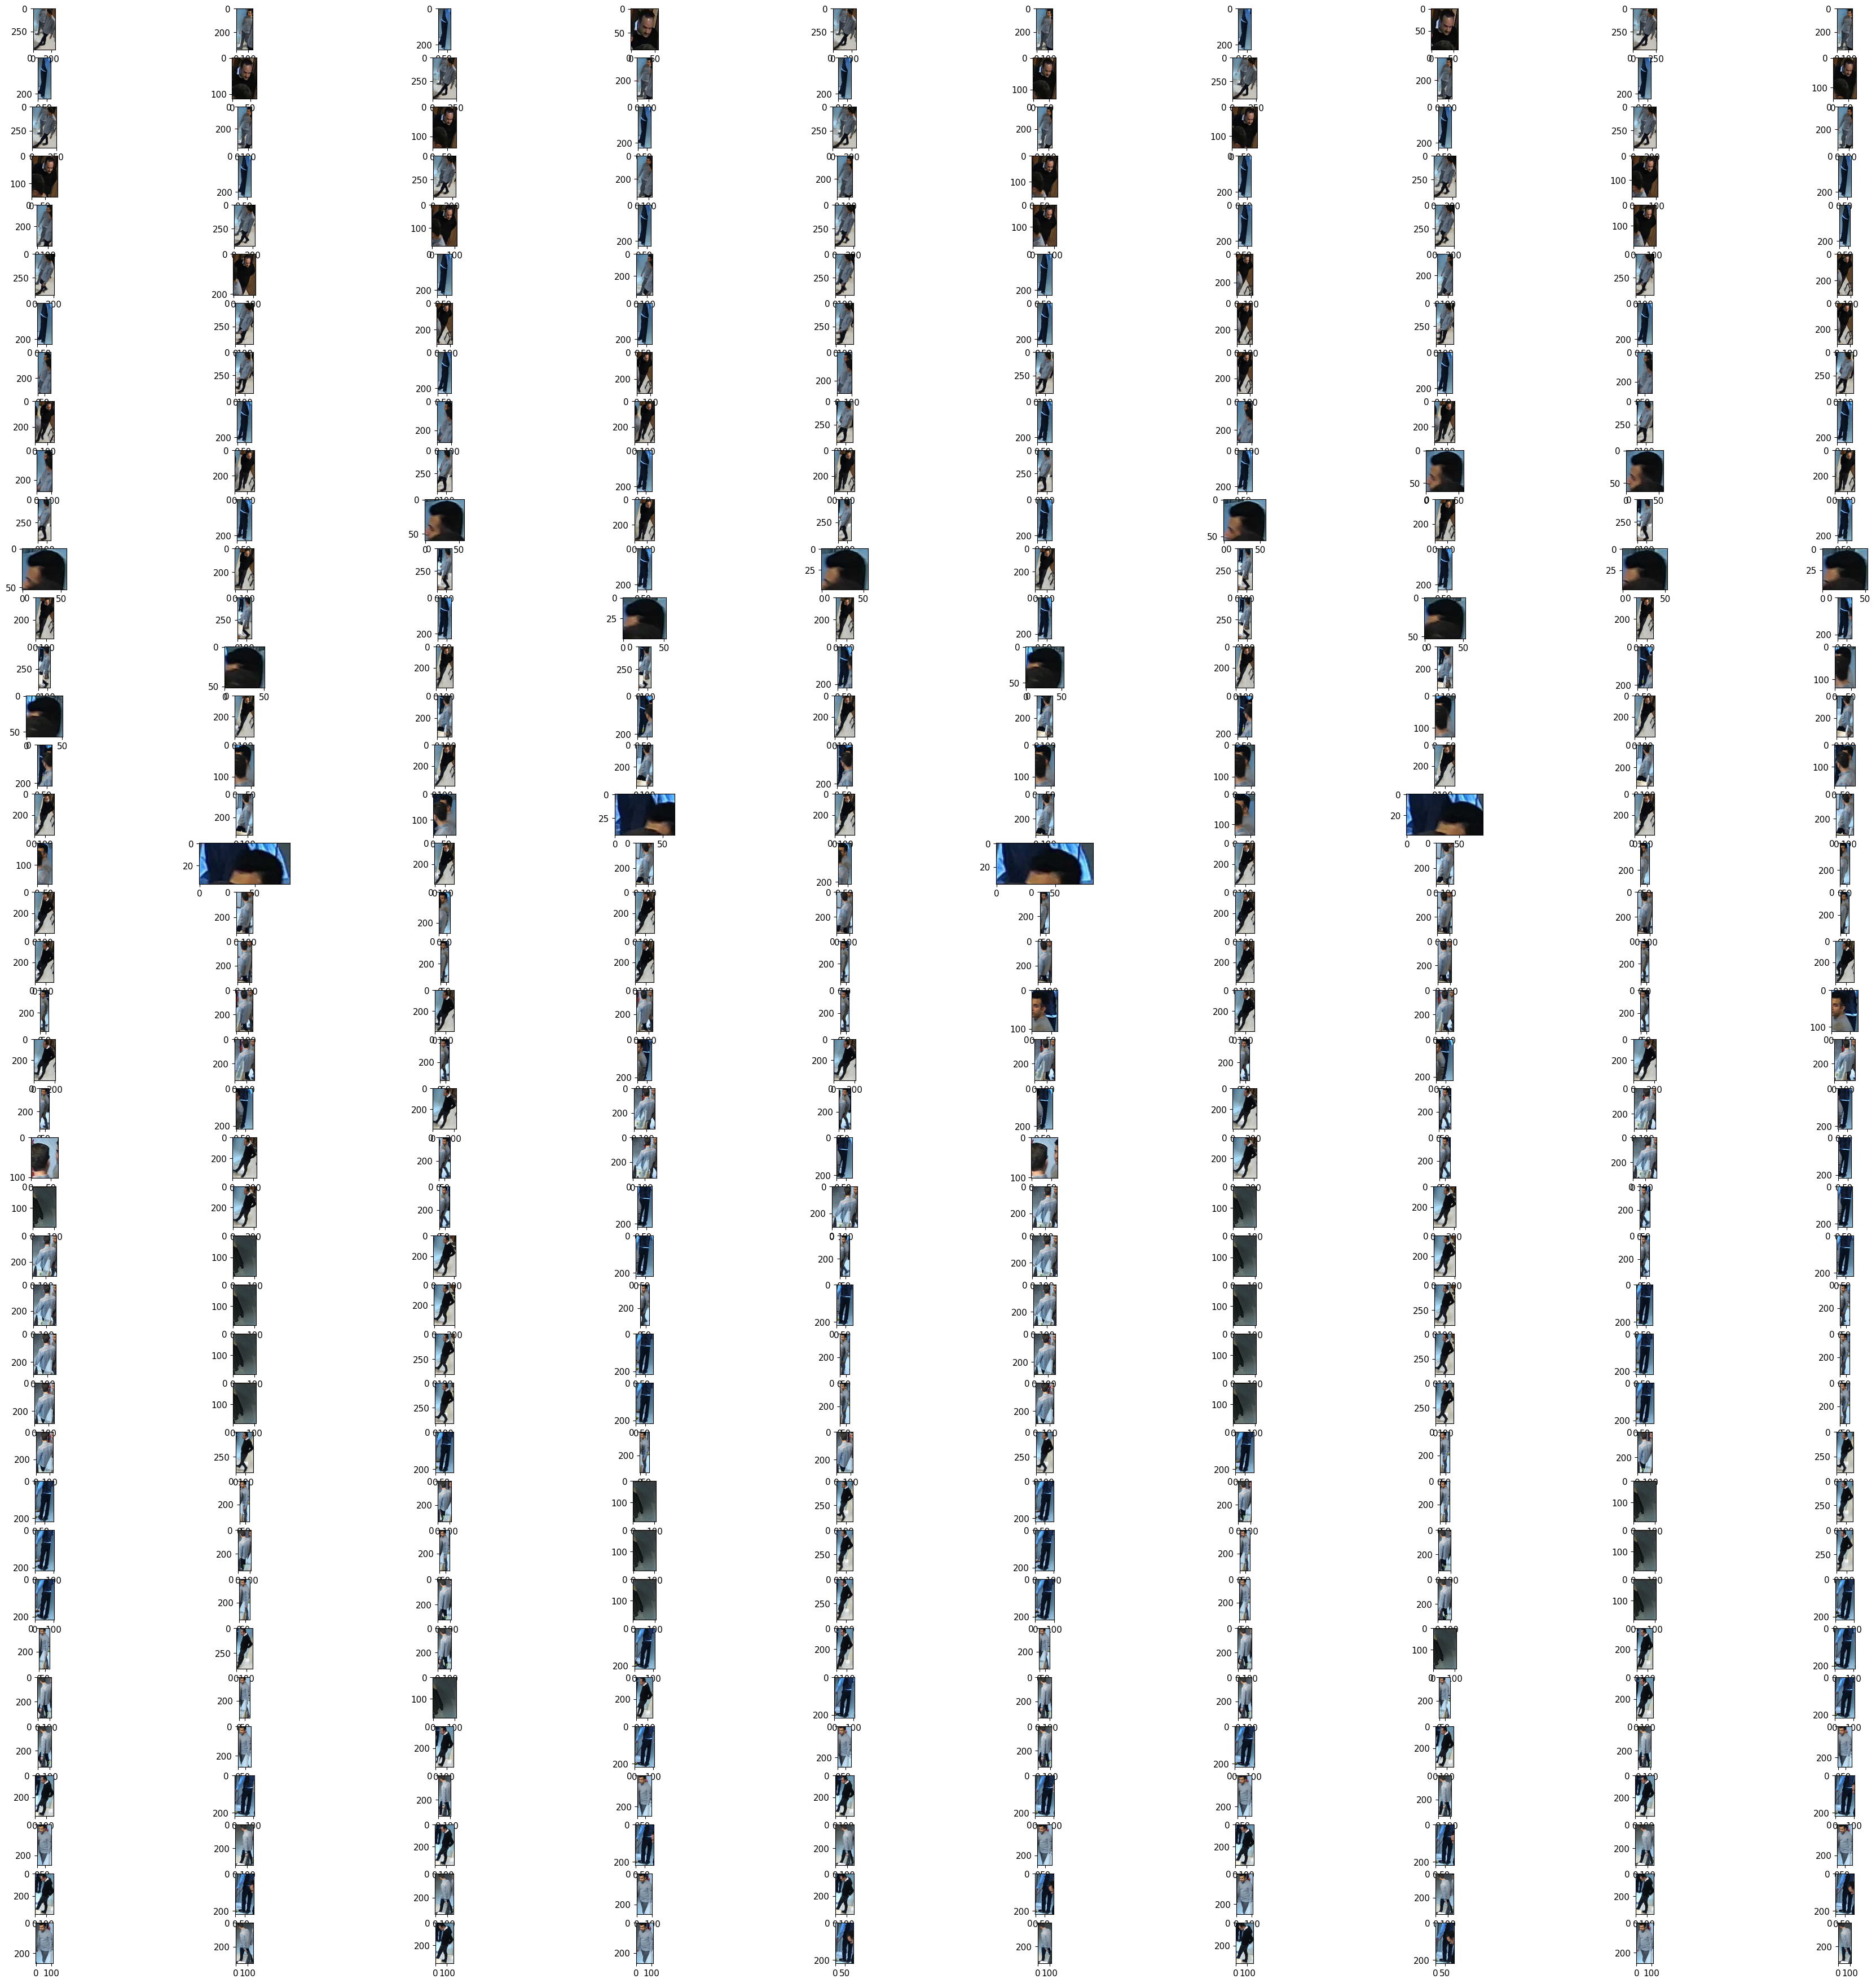

In [122]:
f = plt.figure(figsize=(45,45))

row,col = 40,10
for i in range(row*col):
    f.add_subplot(row,col,i+1)
    try: plt.imshow(imgs_Saved[i+500][1])
    except IndexError: break
plt.show()

## Good Identifications

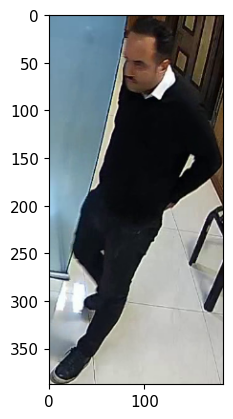

In [64]:
plt.imshow(imgs_Saved[683][1])

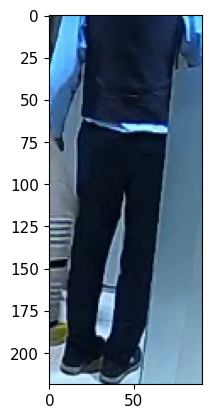

In [66]:
plt.imshow(imgs_Saved[759][1])

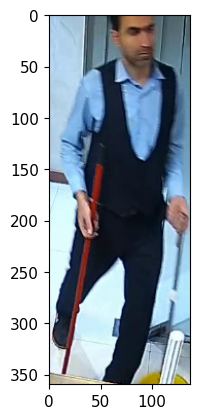

In [75]:
plt.imshow(imgs_Saved[2835][1])

In [20]:
for indx,(_,i) in enumerate(imgs_Saved):
    print(f'{indx} - {i.shape}')

0 - (408, 141, 3)
1 - (408, 141, 3)
2 - (400, 143, 3)
3 - (398, 145, 3)
4 - (395, 147, 3)
5 - (396, 151, 3)
6 - (396, 158, 3)
7 - (395, 182, 3)
8 - (395, 182, 3)
9 - (395, 181, 3)
10 - (396, 178, 3)
11 - (396, 169, 3)
12 - (395, 163, 3)
13 - (394, 153, 3)
14 - (392, 154, 3)
15 - (390, 149, 3)
16 - (389, 149, 3)
17 - (386, 150, 3)
18 - (380, 151, 3)
19 - (377, 153, 3)
20 - (375, 155, 3)
21 - (374, 157, 3)
22 - (374, 157, 3)
23 - (377, 157, 3)
24 - (377, 155, 3)
25 - (380, 153, 3)
26 - (384, 152, 3)
27 - (385, 147, 3)
28 - (381, 141, 3)
29 - (380, 138, 3)
30 - (370, 135, 3)
31 - (365, 130, 3)
32 - (364, 127, 3)
33 - (364, 124, 3)
34 - (364, 123, 3)
35 - (365, 124, 3)
36 - (364, 123, 3)
37 - (363, 123, 3)
38 - (361, 122, 3)
39 - (361, 123, 3)
40 - (361, 123, 3)
41 - (360, 123, 3)
42 - (360, 123, 3)
43 - (360, 122, 3)
44 - (360, 122, 3)
45 - (360, 121, 3)
46 - (360, 120, 3)
47 - (360, 120, 3)
48 - (361, 119, 3)
49 - (361, 123, 3)
50 - (361, 123, 3)
51 - (361, 122, 3)
52 - (361, 122, 3)
53 

## Worst Identifications

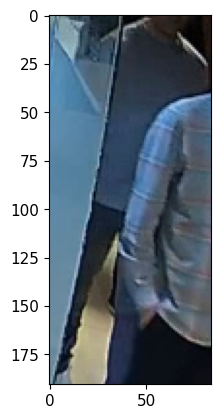

In [87]:
plt.imshow(imgs_Saved[253][1])

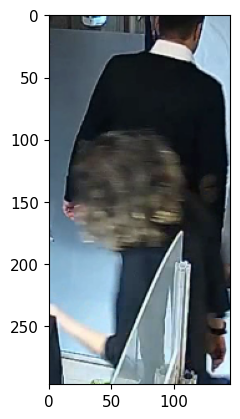

In [82]:
plt.imshow(imgs_Saved[1769][1])

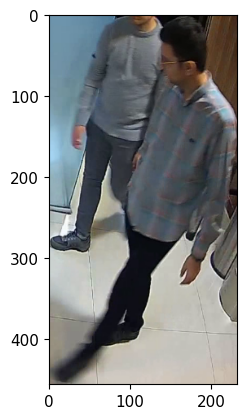

In [57]:
plt.imshow(imgs_Saved[497][1])

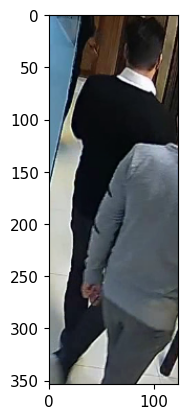

In [80]:
plt.imshow(imgs_Saved[2867][1])

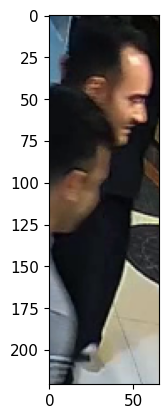

In [78]:
plt.imshow(imgs_Saved[2803][1])

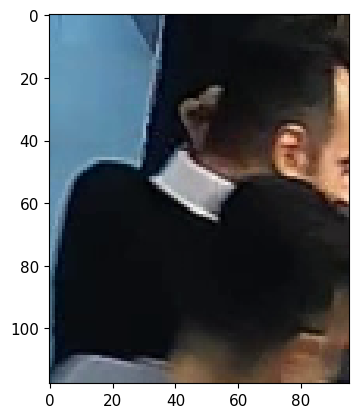

In [77]:
plt.imshow(imgs_Saved[2818][1])

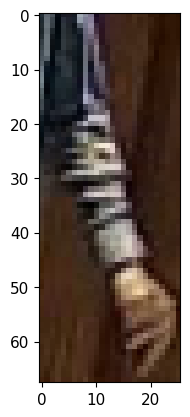

In [86]:
plt.imshow(imgs_Saved[141][1])

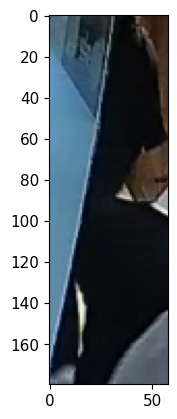

In [76]:
plt.imshow(imgs_Saved[2847][1])

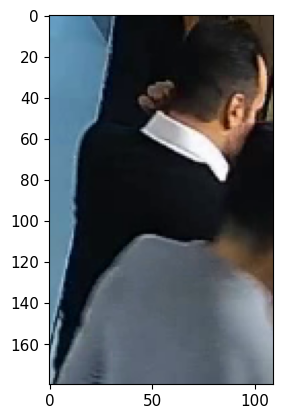

In [74]:
plt.imshow(imgs_Saved[2836][1])

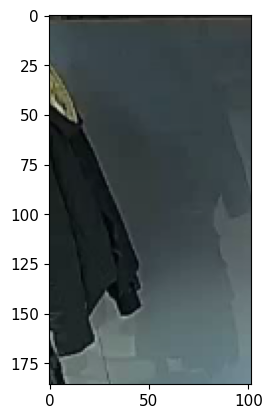

In [73]:
plt.imshow(imgs_Saved[2924][1])

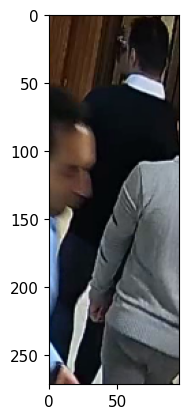

In [72]:
plt.imshow(imgs_Saved[2931][1])

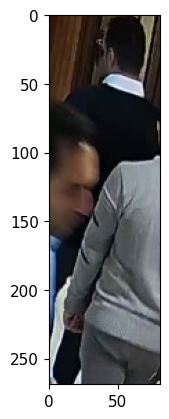

In [71]:
plt.imshow(imgs_Saved[2941][1])

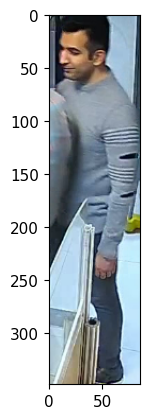

In [69]:
plt.imshow(imgs_Saved[812][1])

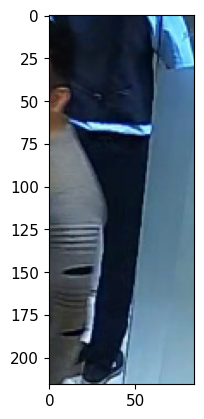

In [65]:
plt.imshow(imgs_Saved[725][1])

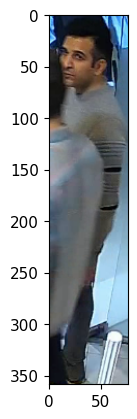

In [63]:
plt.imshow(imgs_Saved[689][1])

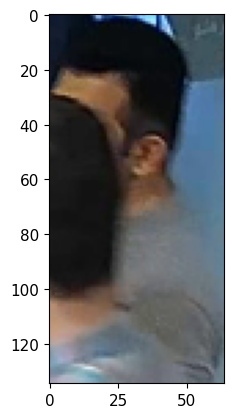

In [60]:
plt.imshow(imgs_Saved[666][1])

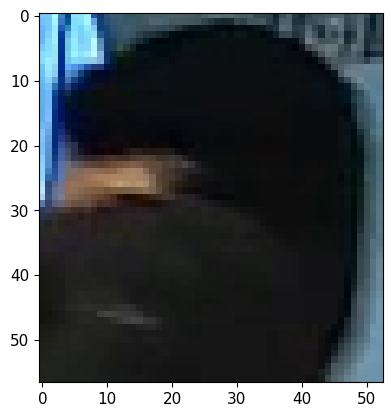

In [58]:
plt.imshow(imgs_Saved[635][1])

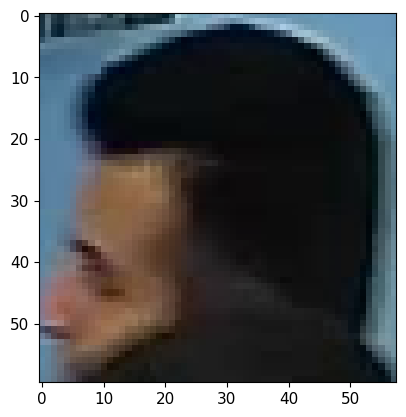

In [56]:
plt.imshow(imgs_Saved[602][1])

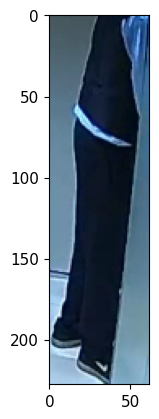

In [52]:
plt.imshow(imgs_Saved[549][1])

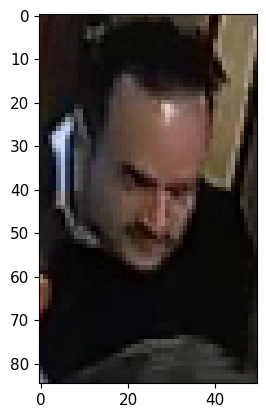

In [51]:
plt.imshow(imgs_Saved[499][1])